In [136]:
import db_dtypes
print("db-dtypes installed successfully!")

db-dtypes installed successfully!


In [137]:
# import seaborn
import seaborn as sns

In [138]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import matplotlib.pyplot as plt

# Path to your service account key
key_path = "/mnt/c/Users/linze/Documents/sctp/dsai-module-2-final-project/final-project-57294-63425154d98b.json"

# Set up the credentials
creds = service_account.Credentials.from_service_account_file(key_path)

# Initialize BigQuery client with credentials
client = bigquery.Client(credentials=creds)

# Specify the dataset and table IDs
dataset_id = 'ds_olist_fact'
table_id = 'fact_order'

# Write the SQL query to select data from the view
query = f"""
SELECT *
FROM `{dataset_id}.{table_id}`
"""

# Run the query and get the result as a pandas DataFrame
df = client.query(query).to_dataframe()

# Print the first few rows of the dataframe
print(df.head())


/home/cindy/miniconda3/envs/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1900: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


                        customer_id                          order_id  \
0  8886130db0ea6e9e70ba0b03d7c0d286  a2e4c44360b4a57bdff22f3a4630c173   
1  b2191912d8ad6eac2e4dc3b6e1459515  132f1e724165a07f6362532bfb97486e   
2  622e13439d6b5a0b486c435618b2679e  809a282bbd5dbcabb6f2f724fca862ec   
3  b6f6cbfc126f1ae6723fe2f9b3751208  e5215415bb6f76fe3b7cb68103a0d1c0   
4  b106b360fe2ef8849fbbd056f777b4d5  71303d7e93b399f5bcd537d124c0bcfa   

  order_purchase_timestamp  payment_value payment_type  \
0      2017-02-06 20:18:17          61.62  credit_card   
1      2017-04-25 01:25:34         179.46  credit_card   
2      2016-09-13 15:24:19          40.95  credit_card   
3      2016-10-22 08:25:27          61.99      voucher   
4      2016-10-02 22:07:52         109.34  credit_card   

  purchase_month_and_year  purchase_year  
0                 2017-02           2017  
1                 2017-04           2017  
2                 2016-09           2016  
3                 2016-10           2016

In [139]:
df.describe()

,order_purchase_timestamp,payment_value,purchase_year
count,103886,103886.000000,103886.0
mean,2017-12-29 21:48:47.671803,154.100380,2017.535866
min,2016-09-04 21:15:19,0.000000,2016.0
25%,2017-09-10 09:01:08.750000,56.790000,2017.0
50%,2018-01-17 14:07:54,100.000000,2018.0
75%,2018-05-03 18:35:58.250000,171.837500,2018.0
max,2018-10-17 17:30:18,13664.080000,2018.0
std,NaN,217.494064,0.505349


In [140]:
# save the data to a csv file
df.to_csv('factable.csv')

###Total Sales by month for past years

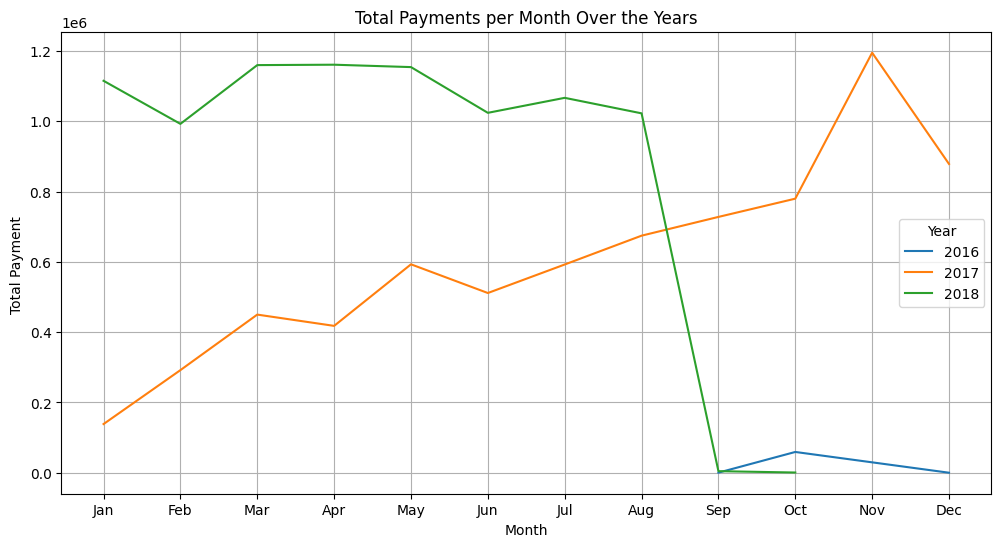

In [141]:
# Ensure 'purchase_month_and_year' is in datetime format
df['purchase_month_and_year'] = pd.to_datetime(df['purchase_month_and_year'])

# Extract year and month separately
df['purchase_year'] = df['purchase_month_and_year'].dt.year
df['purchase_month'] = df['purchase_month_and_year'].dt.month  # Extract month (1-12)

# Group by 'purchase_month' and 'purchase_year' to sum 'payment_value'
df_grouped = df.groupby(['purchase_month', 'purchase_year'])['payment_value'].sum().reset_index()

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_grouped, x='purchase_month', y='payment_value', hue='purchase_year', palette="tab10")

# Customize x-axis to show only month names (Jan–Dec)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.xlabel('Month')
plt.ylabel('Total Payment ')
plt.title('Total Payments per Month Over the Years')
plt.legend(title="Year")
plt.grid(True)
plt.show()

###### The followin month is the best seller month

### Nov 2017 and Jan-May 2018

Sales trend analysis

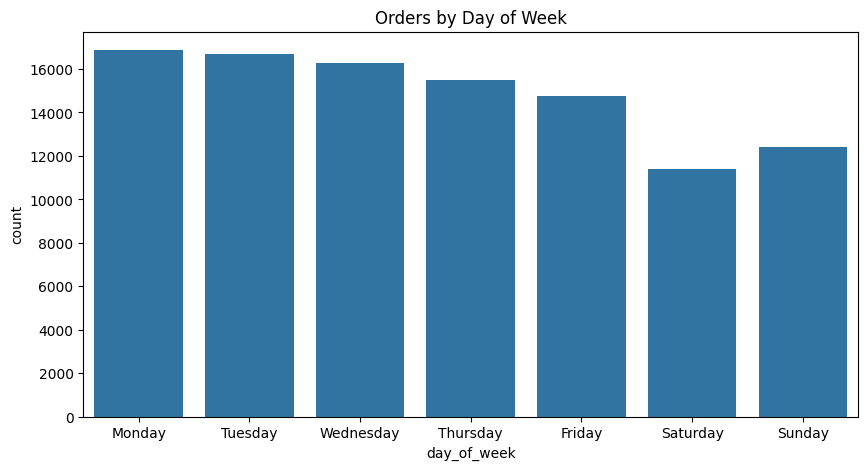

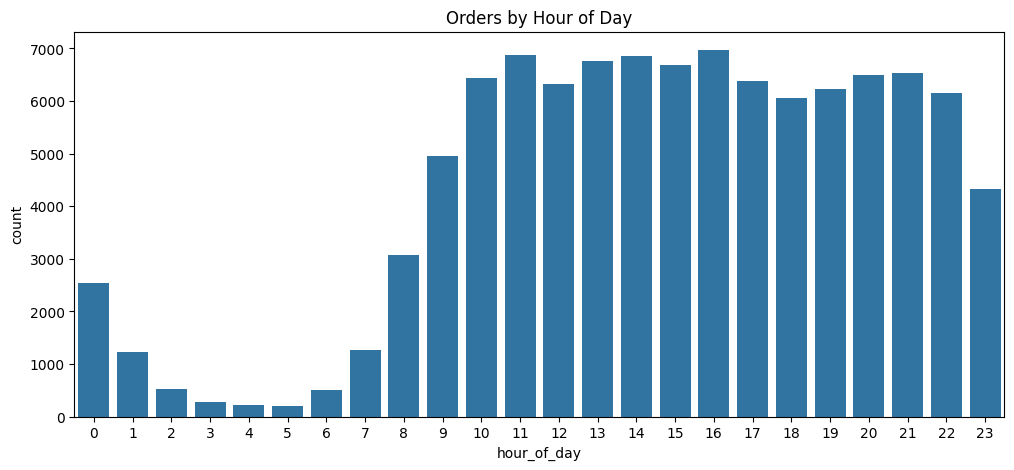

In [142]:
# plot chart for average payment value per weekday over years vs average order 
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
# Daily/weekly patterns
df['day_of_week'] = df['order_purchase_timestamp'].dt.day_name()
df['hour_of_day'] = df['order_purchase_timestamp'].dt.hour

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='day_of_week', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Orders by Day of Week')
plt.show()

plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='hour_of_day')
plt.title('Orders by Hour of Day')
plt.show()

Finding:
9am-23am is the peak selling hours


Customer Analysis

 ####Recency: How recently a customer has made a purchase. Frequency: How often a customer makes a purchase. Monetary value: How much money a customer spends on purchases.

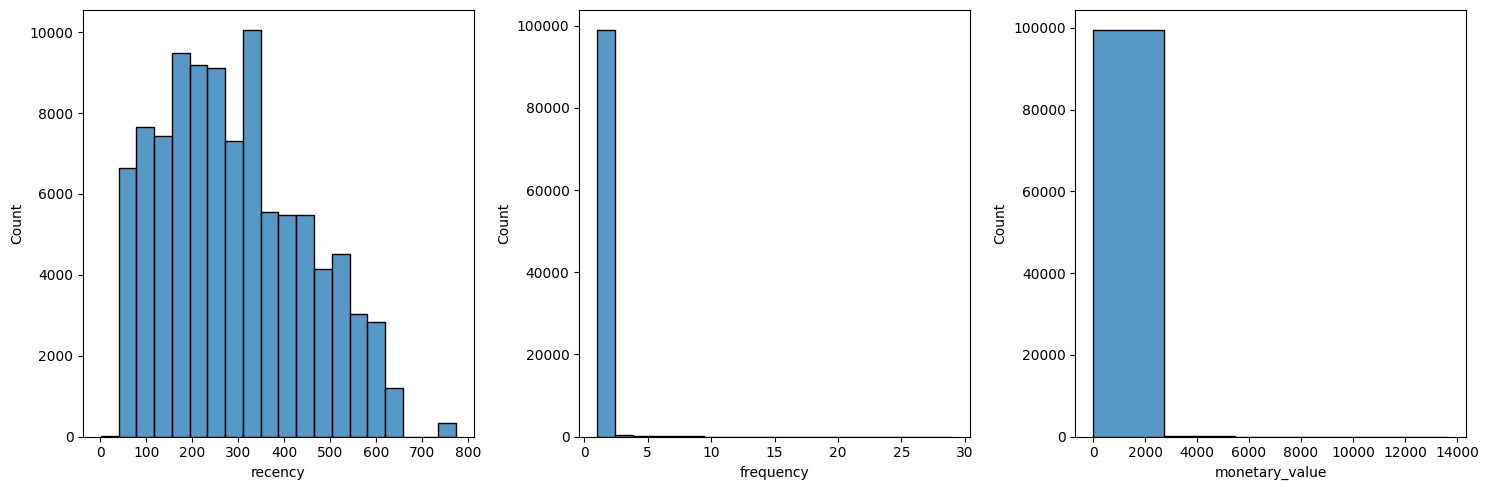

In [143]:
# Customer segmentation by purchase behavior
customer_stats = df.groupby('customer_id').agg({
    'payment_value': ['sum', 'mean', 'count'],
    'order_purchase_timestamp': ['min', 'max']
}).reset_index()

customer_stats.columns = ['customer_id', 'total_spend', 'avg_order_value', 'order_count', 'first_purchase', 'last_purchase']

# RFM Analysis
import datetime as dt
snapshot_date = df['order_purchase_timestamp'].max() + dt.timedelta(days=1)

rfm = df.groupby('customer_id').agg({
    'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,
    'order_id': 'count',
    'payment_value': 'mean'# Monetary value should be sum of all payments,change to average
})

rfm.rename(columns={
    'order_purchase_timestamp': 'recency',
    'order_id': 'frequency',
    'payment_value': 'monetary_value'
}, inplace=True)

# Plot RFM distributions
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(rfm['recency'], bins=20, ax=ax[0])
sns.histplot(rfm['frequency'], bins=20, ax=ax[1])
sns.histplot(rfm['monetary_value'], bins=5, ax=ax[2])
plt.tight_layout()
plt.show()

In [144]:
snapshot_date 


Timestamp('2018-10-18 17:30:18')

The three histograms created in the last part of the code represent different aspects of customer purchasing behavior:

Recency Distribution (ax[0])

X-axis: Recency (Days since last purchase)

Y-axis: Number of customers

Meaning:

A high bar on the left → Many customers have purchased recently.

A high bar on the right → Many customers haven’t purchased in a long time (inactive customers).

Frequency Distribution (ax[1])

X-axis: Number of orders per customer

Y-axis: Number of customers

Meaning:

A peak on the left (low order counts) → Most customers buy only once or twice.

A peak on the right (high order counts) → Some customers are frequent buyers.

Monetary Value Distribution (ax[2])

X-axis: Total amount spent per customer

Y-axis: Number of customers

Meaning:

A peak at low values → Most customers spend a small amount.

A long right tail → A few high-spending customers (VIPs).



### Top 20 customers by RFM scores

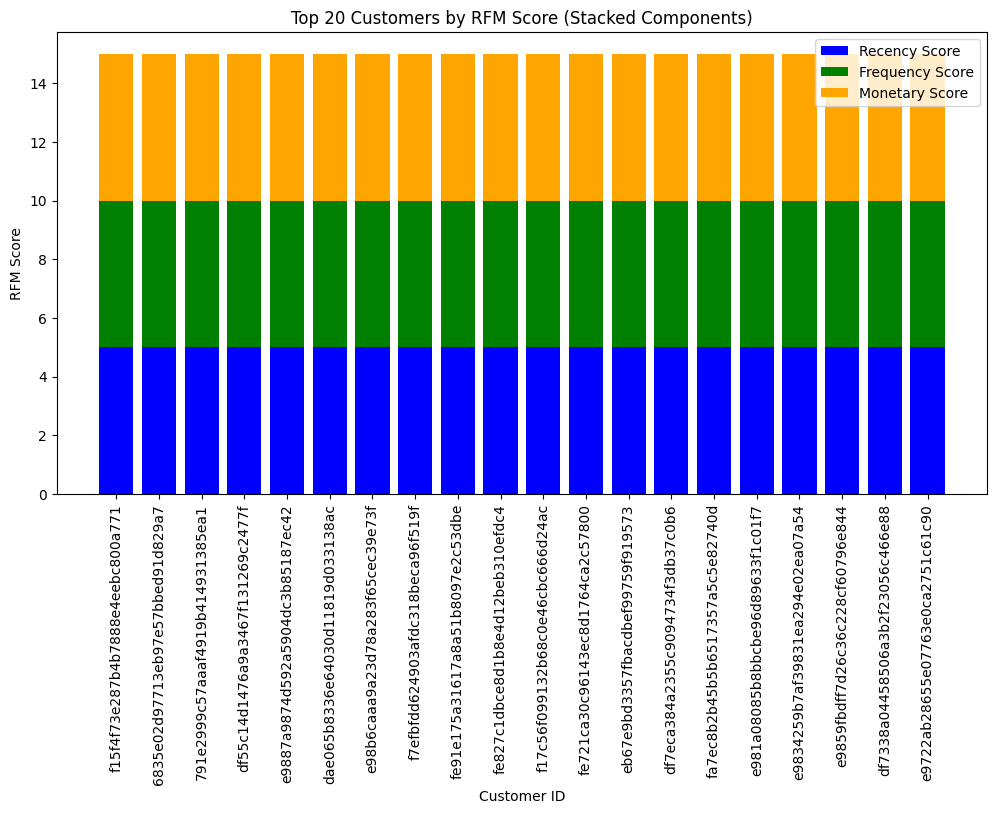

In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure RFM scores are computed correctly
rfm['R_Score'] = pd.qcut(rfm['recency'], 5, labels=False, duplicates='drop') + 1
rfm['F_Score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=False, duplicates='drop') + 1
rfm['M_Score'] = pd.qcut(rfm['monetary_value'], 5, labels=False, duplicates='drop') + 1

# Convert scores to integers
rfm[['R_Score', 'F_Score', 'M_Score']] = rfm[['R_Score', 'F_Score', 'M_Score']].astype(int)

# Calculate overall RFM Score
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

# Select top 20 customers based on RFM Score
top_20_customers = rfm.sort_values(by='RFM_Score', ascending=False).head(20)

# Reset index for better visualization
top_20_customers = top_20_customers.reset_index()

# Plot stacked bar chart with different colors
plt.figure(figsize=(12, 6))

# Plot each RFM component with different colors
plt.bar(top_20_customers['customer_id'], top_20_customers['R_Score'], color='blue', label='Recency Score')
plt.bar(top_20_customers['customer_id'], top_20_customers['F_Score'], 
        bottom=top_20_customers['R_Score'], color='green', label='Frequency Score')
plt.bar(top_20_customers['customer_id'], top_20_customers['M_Score'], 
        bottom=top_20_customers['R_Score'] + top_20_customers['F_Score'], color='orange', label='Monetary Score')

# Labels, Title, and Legend
plt.xlabel('Customer ID')
plt.ylabel('RFM Score')
plt.title('Top 20 Customers by RFM Score (Stacked Components)')
plt.xticks(rotation=90)
plt.legend()

# Show the chart
plt.show()


1️⃣ Recency (R) is High → Purchased recently
2️⃣ Frequency (F) is High → Purchases often
3️⃣ Monetary (M) is High → Spends a lot

Such customers are engaged, loyal, and valuable to the business.

Product Analysis

In [146]:
# import data from bigquery #dim order_list
# Specify the dataset and table IDs
dataset_id = 'ds_olist_fact'
table_id = 'fact_order_items'

# Write the SQL query to select data from the view
query = f"""
SELECT *
FROM `{dataset_id}.{table_id}`
"""

# Run the query and get the result as a pandas DataFrame
df1 = client.query(query).to_dataframe()

# Print the first few rows of the dataframe
print(df1.head())


/home/cindy/miniconda3/envs/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1900: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


                        customer_id                          order_id  \
0  8886130db0ea6e9e70ba0b03d7c0d286  a2e4c44360b4a57bdff22f3a4630c173   
1  8886130db0ea6e9e70ba0b03d7c0d286  a2e4c44360b4a57bdff22f3a4630c173   
2  b2191912d8ad6eac2e4dc3b6e1459515  132f1e724165a07f6362532bfb97486e   
3  b106b360fe2ef8849fbbd056f777b4d5  71303d7e93b399f5bcd537d124c0bcfa   
4  683c54fc24d40ee9f8a6fc179fd9856c  e5fa5a7210941f7d56d0208e4e071d35   

   order_item_id                        product_id  \
0              1  dcecb611ba878d5d8c7853585b285c12   
1              2  dcecb611ba878d5d8c7853585b285c12   
2              1  c4a1c4638fa9e2e4861d141d6e0259e7   
3              1  d2998d7ced12f83f9b832f33cf6507b6   
4              1  f3c2d01a84c947b078e32bbef0718962   

                          seller_id   price  freight_value  \
0  8cc6a0e5738e61a87b03c78b2ba9db4b   19.85          10.96   
1  8cc6a0e5738e61a87b03c78b2ba9db4b   19.85          10.96   
2  5444b12c82f21c923f2639ebc722c1ea  169.90       

In [ ]:
# Load product category translations and product_category_name from product_dataset
df3 = pd.read_csv('/mnt/c/Users/linze/Documents/sctp/dsai-module-2-final-project/data/product_category_name_translation.csv')
df4 = pd.read_csv('/mnt/c/Users/linze/Documents/sctp/dsai-module-2-final-project/data/olist_products_dataset.csv')


# Ensure product_category_name in df4 is not null
df4_filtered = df4[df4['product_category_name'].notna()]

# Create a dictionary mapping 'product_id' to 'product_category_name' in df4
product_category_map = df4_filtered.set_index('product_id')['product_category_name'].to_dict()

# Map 'product_category_name' from df4 to df1 based on 'product_id'
df1['product_category_name'] = df1['product_id'].map(product_category_map)

# Merge df1 with df3 on 'product_category_name'
df1 = df1.merge(df3, on='product_category_name', how='left')


# Display the first few rows to check
df1.head()



,customer_id,order_id,order_item_id,product_id,seller_id,price,freight_value,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,product_category_name_from_df4,product_category_name,product_category_name_english
0,8886130db0ea6e9e70ba0b03d7c0d286,a2e4c44360b4a57bdff22f3a4630c173,1,dcecb611ba878d5d8c7853585b285c12,8cc6a0e5738e61a87b03c78b2ba9db4b,19.85,10.96,2017-02-06 20:30:19,NaT,2017-03-01,informatica_acessorios,informatica_acessorios,computers_accessories
1,8886130db0ea6e9e70ba0b03d7c0d286,a2e4c44360b4a57bdff22f3a4630c173,2,dcecb611ba878d5d8c7853585b285c12,8cc6a0e5738e61a87b03c78b2ba9db4b,19.85,10.96,2017-02-06 20:30:19,NaT,2017-03-01,informatica_acessorios,informatica_acessorios,computers_accessories
2,b2191912d8ad6eac2e4dc3b6e1459515,132f1e724165a07f6362532bfb97486e,1,c4a1c4638fa9e2e4861d141d6e0259e7,5444b12c82f21c923f2639ebc722c1ea,169.90,9.56,2017-04-30 20:32:41,NaT,2017-05-22,utilidades_domesticas,utilidades_domesticas,housewares
3,b106b360fe2ef8849fbbd056f777b4d5,71303d7e93b399f5bcd537d124c0bcfa,1,d2998d7ced12f83f9b832f33cf6507b6,25e6ffe976bd75618accfe16cefcbd0d,100.00,9.34,2016-10-06 15:50:56,NaT,2016-10-25,bebes,bebes,baby
4,683c54fc24d40ee9f8a6fc179fd9856c,e5fa5a7210941f7d56d0208e4e071d35,1,f3c2d01a84c947b078e32bbef0718962,a425f92c199eb576938df686728acd20,59.50,15.56,2016-10-07 13:17:15,NaT,2016-10-28,telefonia,telefonia,telephony


Top 20 Product Category Distribution(qty)

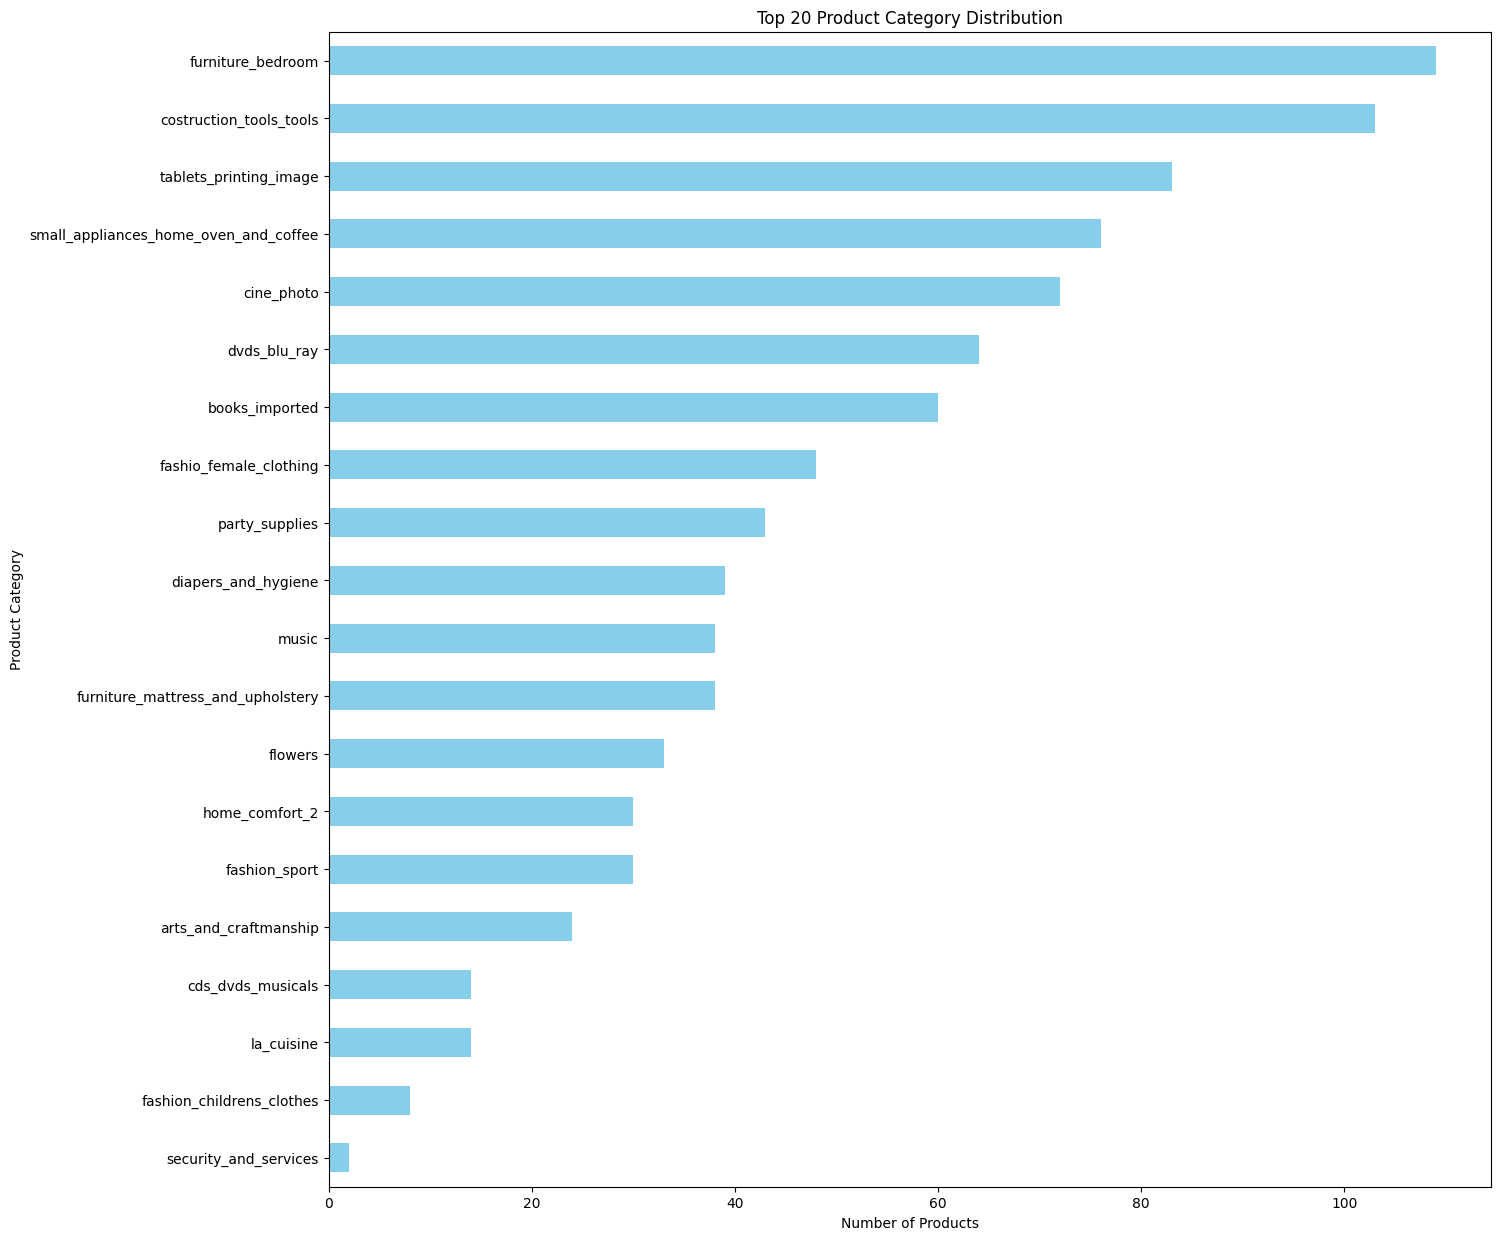

In [153]:
# Product category distribution (Horizontal Bar Chart)
import matplotlib.pyplot as plt

# Count the number of products in each category in descending order
category_distribution = df1['product_category_name_english'].value_counts().sort_values(ascending=True).head(20)

# Plot the distribution as a horizontal bar chart
plt.figure(figsize=(15, 15))
category_distribution.plot(kind='barh', color='skyblue')
plt.title('Top 20 Product Category Distribution')
plt.xlabel('Number of Products')
plt.ylabel('Product Category')
plt.show()


Top 20 Sales Performance per Category

<Figure size 2000x2000 with 0 Axes>

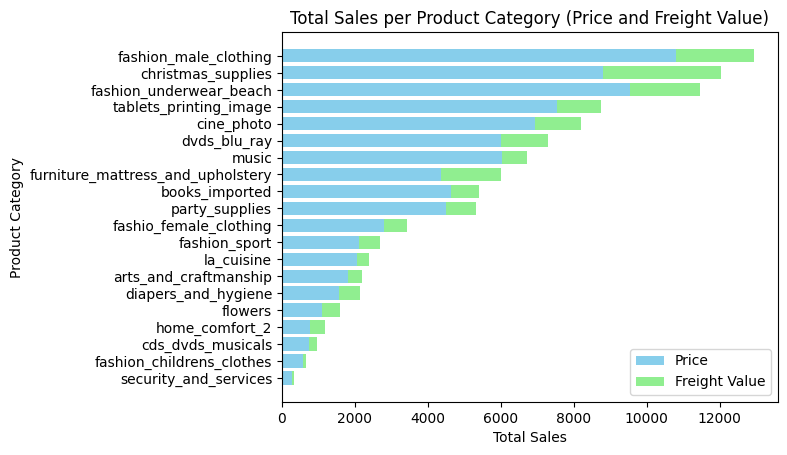

In [154]:
# Calculate total sales per category (price + freight_value)
df1['total_sales'] = df1['price'] + df1['freight_value']

# Group by product category and calculate the sum of price and freight_value separately
sales_price = df1.groupby('product_category_name_english')['price'].sum()
sales_freight = df1.groupby('product_category_name_english')['freight_value'].sum()

# Calculate total sales by adding price and freight value
total_sales = sales_price + sales_freight

# Sort categories by total sales in descending order
sorted_total_sales = total_sales.sort_values(ascending=True).head(20)

# Plot total sales per category, stacked by price and freight value
plt.figure(figsize=(20, 20))
fig, ax = plt.subplots()

# Plot price and freight value on the same horizontal bar chart
ax.barh(sorted_total_sales.index, sales_price[sorted_total_sales.index], color='skyblue', label='Price')
ax.barh(sorted_total_sales.index, sales_freight[sorted_total_sales.index], left=sales_price[sorted_total_sales.index], color='lightgreen', label='Freight Value')

# Adding titles and labels
plt.title('Total Sales per Product Category (Price and Freight Value)')
plt.xlabel('Total Sales')
plt.ylabel('Product Category')

# Add legend to show what each color represents
plt.legend()

plt.show()


The Top 20 by sales amount differ from the Top 20 by quantity sold because expensive products bring in more money but are sold less frequently. For example, Fashion_male_clothing ranks high in sales amount due to its high price but not in quantity sold. This suggests that in regions like Europe, males prefer to buy quality, expensive clothes.